In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.model_selection import train_test_split

import datetime as dt
from datetime import timedelta

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import Javascript
import gc
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import average_precision_score, precision_recall_curve, auc
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import random
import pickle

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [19]:
from matplotlib import pyplot as plt

In [2]:
top3_df = pd.read_hdf('../../data/feature/2020-11-09/data_top3.hdf')
top3_df.shape
top3_df = top3_df[~top3_df.w0_lateness_increase_days.isna()]
top3_df.shape
target_clf =  ['w0_lateness_increase']

is_reduce_to_NoNA = False

(1520028, 55)

(1240127, 55)

In [3]:
index_columns = ['item_name', 'item_pl_name', 'demand_type', 'demand_type_group', 'demand_type_parent', 'plan_type', 'requested_delivery_week', 'run_time_date']

target_columns = ['w1_is_lateness', 'w0_is_lateness', 'demand_request_days_late_weighted', 'w0_lateness_increase_days', 'w1_lateness_increase_days', 'w0_lateness_increase', 'w1_lateness_increase']
constant_columns = ['plan_type_id', 'demand_type_group_id', 'demand_priority']

top3_df.reset_index(inplace=True)
all_features_fields = top3_df.columns.tolist()
for feat_to_remove in target_columns:
    all_features_fields.remove(feat_to_remove)

cut_off_start = '2020-01-01'
cut_off_train = '2020-07-11'
# cut_off_end = '2020-08-08'
cut_off_end = '2020-08-15'

In [4]:
top3_df.run_time_date.max()
top3_df[top3_df.run_time_date == top3_df.run_time_date.max()].shape

'2020-08-15'

(41478, 63)

### Whether to reduce data by removing all Nulls 

In [5]:
if is_reduce_to_NoNA:
    top3_df.isnull().sum()
    df_noNA = top3_df.dropna(how='any', axis=0)
    df_noNA.isnull().sum()
    top3_df.shape, df_noNA.shape
    df_train = df_noNA[(df_noNA['run_time_date'] < cut_off_train)]
    df_test = df_noNA[(df_noNA['run_time_date'] >= cut_off_train) & (df_noNA['run_time_date'] <= cut_off_end)]
else:
    df_train = top3_df[(top3_df['run_time_date'] < cut_off_train)]
    df_test = top3_df[(top3_df['run_time_date'] >= cut_off_train) & (top3_df['run_time_date'] <= cut_off_end)]

### Creating train and test independent and target variable

In [6]:
X_train = df_train[all_features_fields]
X_test = df_test[all_features_fields]

X_train = X_train.set_index(index_columns)
X_test = X_test.set_index(index_columns)

y_train = df_train[target_clf]
y_test = df_test[target_clf]

In [7]:
df_count = pd.DataFrame(df_train[target_clf]['w0_lateness_increase'].value_counts()).reset_index(drop=True)
scaled_weight = df_count['w0_lateness_increase'][0]/df_count['w0_lateness_increase'][1]
scaled_weight

6.085693490034894

In [8]:
X_test.shape

(247145, 48)

### model selection pipeline

In [9]:
xgb_michelin = xgb.XGBClassifier(base_score=0.885, n_estimators=75, learning_rate=.1, max_depth=5, seed=42)
xgb_tuned = xgb.XGBClassifier(colsample_bytree= 0.5, eta= 0.1, gamma= 0, subsample= 0.8, seed=42)
xgb_default = xgb.XGBClassifier(seed=42)
xgb_scaledweight  = xgb.XGBClassifier(scale_pos_weight = scaled_weight, seed=42)
lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
dt_depthreduced = DecisionTreeClassifier(max_depth=5, random_state=42)
rf = RandomForestClassifier(random_state=42)
rf_classbalanced = RandomForestClassifier(max_depth = 5, class_weight="balanced", random_state=42)
rf_to_prevent_overfiiting = RandomForestClassifier(n_estimators=150, criterion='gini', min_samples_leaf=3, 
max_features=0.5, n_jobs=-1, oob_score=True, class_weight={0:1,1:6}, random_state=42)

In [10]:
import numpy as np
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=1)

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

fbeta_mu_score, fbeta_sigma_score = [], []
model_list = [xgb_michelin, xgb_tuned, xgb_default, xgb_scaledweight, lr, dt, dt_depthreduced, rf, rf_classbalanced, rf_to_prevent_overfiiting]
for model in model_list:
    obj = model
    scores = cross_val_score(obj, X_train, y_train, cv=5, scoring = ftwo_scorer)
    fbeta_mu_score.append(np.mean(scores))
    fbeta_sigma_score.append(np.std(scores))

In [14]:
fbeta_sigma_score

[0.03637331210739525,
 0.04127793830294689,
 0.037419227276508274,
 0.018887064792020385,
 0.010510000541934603,
 0.017172696757970896,
 0.1002168971211957,
 0.04042010363073586,
 0.04451952122372108,
 0.030531101776661716]

In [13]:
fbeta_mu_score

[0.5218394111256172,
 0.5405341085128157,
 0.5657153254564531,
 0.6052878527263861,
 0.016700870157877502,
 0.4909658510047873,
 0.4082901410236208,
 0.5225311427710501,
 0.5116012008337446,
 0.5806855916844154]

In [ ]:
### Repeat above step for NoNaNs data

### Sampling to represent population and then checking on random sample of test vs time sliced test data

In [15]:
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
len(numeric_cols)

48

#### check whether time based train and test dat characteristics are same or diff

train and test are appearing different distributions

In [17]:
from scipy.stats import ks_2samp
def kstest(olddata, newdata, numeric_cols):
    count_list = 0
    same_list, diff_list = [], []
    for col in numeric_cols:
        oldvar = olddata[col]
        newvar = newdata[col]
        (s,p) = ks_2samp(oldvar.values.reshape((1,olddata.shape[0]))[0], newvar.values.reshape((1,newdata.shape[0]))[0])
#         print(col, s, p)
        if p > 0.05:
            same_list.append(col)
#             print("same")
            count_list += 1
        else:
            diff_list.append(col)
    if count_list/len(numeric_cols) > 0.5:
        
        return 'same', same_list, diff_list
    else:
        return 'different', same_list, diff_list

same_diff, same_list, diff_list = kstest(X_train, X_test, numeric_cols)
print(same_diff)
print(same_list)
print(diff_list)

different
['sso_min_stock', 'sso_rampup_stock', 'sso_retain_stock', 'sso_safety_stock', 'delta_sso_min_stock', 'delta_sso_rampup_stock', 'delta_sso_retain_stock', 'delta_sso_safety_stock', 'delta_yield']
['plan_type_id', 'demand_priority', 'demand_type_group_id', 'or_demand_request_qty', 'or_derived_demand_request_qty', 'or_total_demand_request_qty', 'ordergroupsum', 'ordergroupsum_percent', 'de_disaggregated_quantity', 'co_customer_order_qty_rmad', 'co_customer_order_qty_cmad', 'sso_max_stock', 'ic_ending_on_hand_inv', 'ic_min_target_stock', 'target_delta', 'ic_begin_on_hand_inv_first_bkt', 'yield', '1st_bn_utilization', '1st_bn_consumption', '1st_bn_pcs', '2nd_bn_utilization', '2nd_bn_consumption', '2nd_bn_pcs', '3rd_bn_utilization', '3rd_bn_consumption', '3rd_bn_pcs', 'delta_or_demand_request_qty', 'delta_or_derived_demand_request_qty', 'delta_or_total_demand_request_qty', 'delta_ordergroupsum', 'delta_ordergroupsum_percent', 'delta_de_disaggregated_quantity', 'delta_co_customer_ord

### Check on few columns where train and test are differing vs where they are same

Text(0.5, 0, 'sso_min_stock')

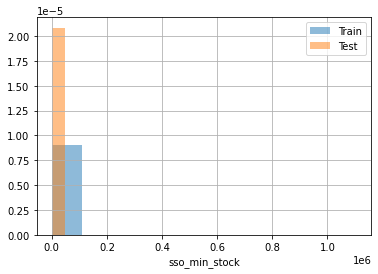

Text(0.5, 0, 'sso_rampup_stock')

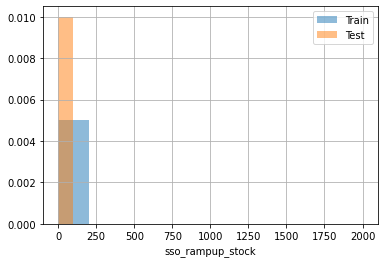

Text(0.5, 0, 'sso_retain_stock')

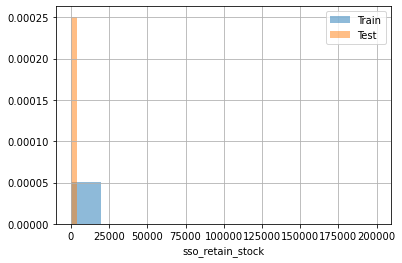

Text(0.5, 0, 'sso_safety_stock')

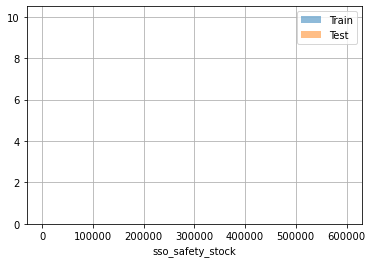

Text(0.5, 0, 'delta_sso_min_stock')

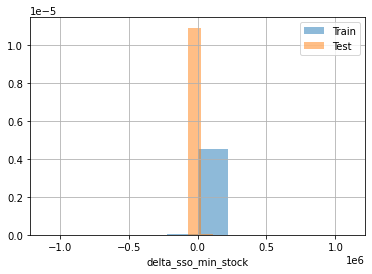

Text(0.5, 0, 'delta_sso_rampup_stock')

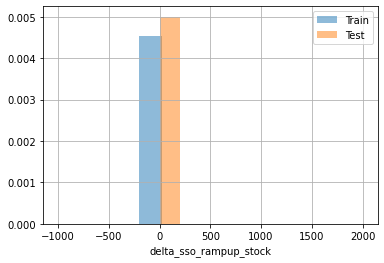

Text(0.5, 0, 'delta_sso_retain_stock')

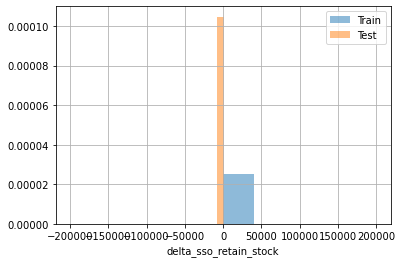

Text(0.5, 0, 'delta_sso_safety_stock')

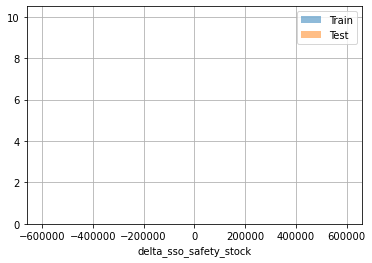

Text(0.5, 0, 'delta_yield')

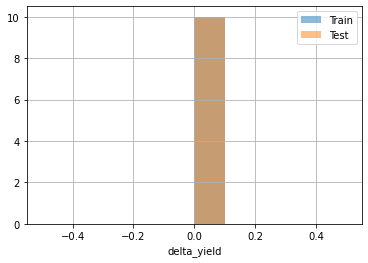

In [25]:
for col in same_list:    
    df_train.loc[:, col].hist(alpha=0.5, label='Train', density=True)    
    df_test.loc[:, col].hist(alpha=0.5, label='Test', density=True)
    plt.xlabel(col)
    plt.legend()
    plt.show()

Text(0.5, 0, 'plan_type_id')

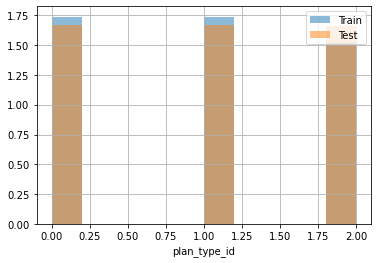

Text(0.5, 0, 'demand_priority')

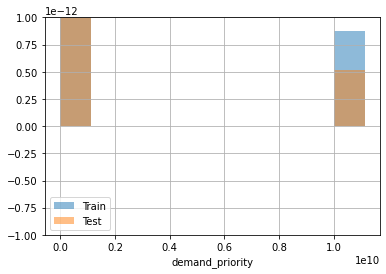

Text(0.5, 0, 'demand_type_group_id')

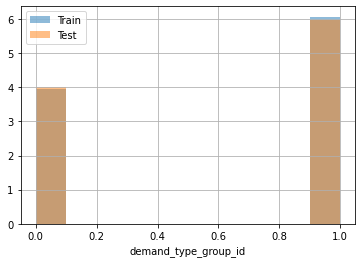

Text(0.5, 0, 'or_demand_request_qty')

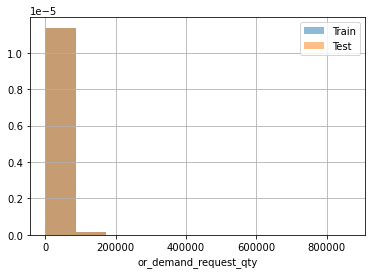

Text(0.5, 0, 'or_derived_demand_request_qty')

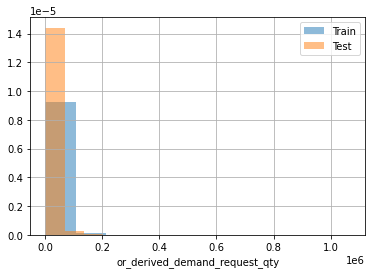

Text(0.5, 0, 'or_total_demand_request_qty')

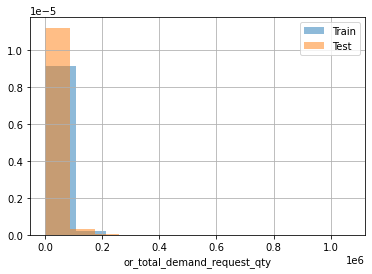

Text(0.5, 0, 'ordergroupsum')

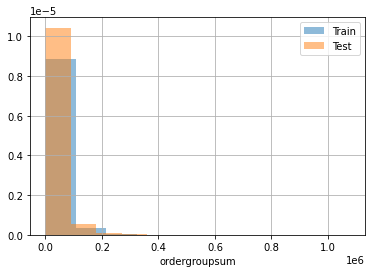

Text(0.5, 0, 'ordergroupsum_percent')

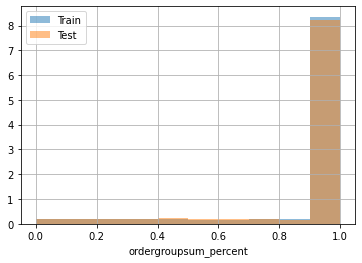

Text(0.5, 0, 'de_disaggregated_quantity')

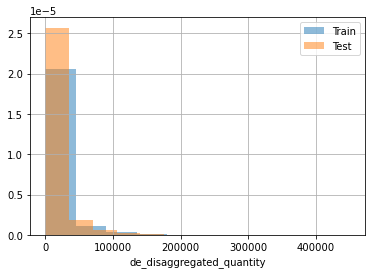

Text(0.5, 0, 'co_customer_order_qty_rmad')

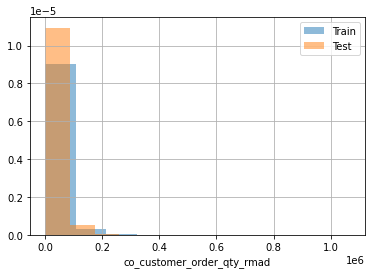

Text(0.5, 0, 'co_customer_order_qty_cmad')

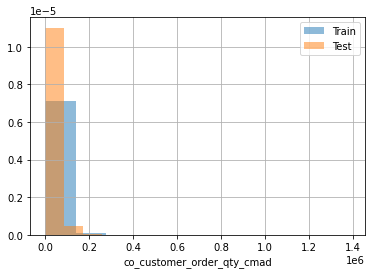

Text(0.5, 0, 'sso_max_stock')

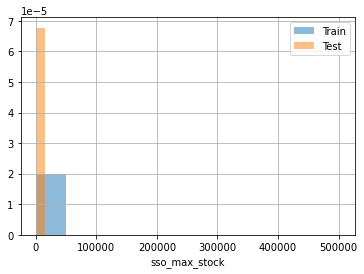

Text(0.5, 0, 'ic_ending_on_hand_inv')

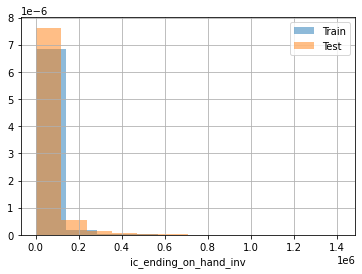

Text(0.5, 0, 'ic_min_target_stock')

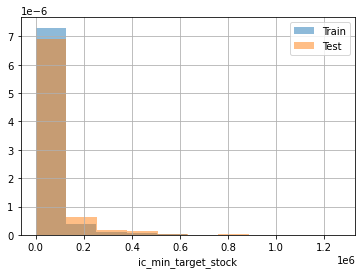

Text(0.5, 0, 'target_delta')

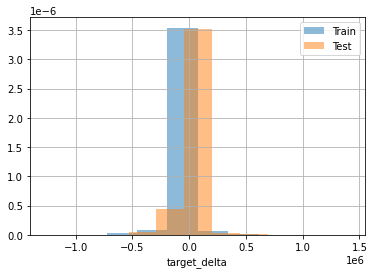

Text(0.5, 0, 'ic_begin_on_hand_inv_first_bkt')

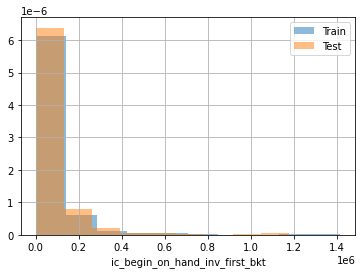

Text(0.5, 0, 'yield')

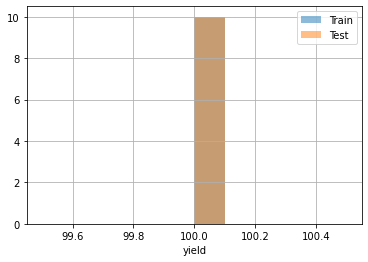

Text(0.5, 0, '1st_bn_utilization')

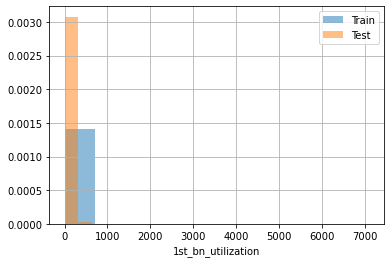

Text(0.5, 0, '1st_bn_consumption')

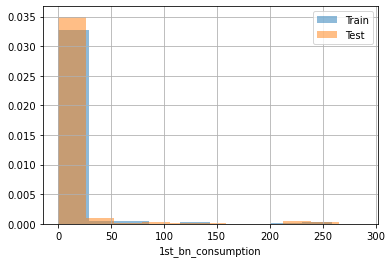

Text(0.5, 0, '1st_bn_pcs')

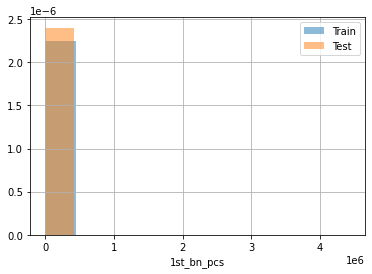

Text(0.5, 0, '2nd_bn_utilization')

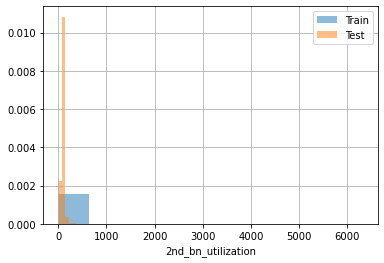

Text(0.5, 0, '2nd_bn_consumption')

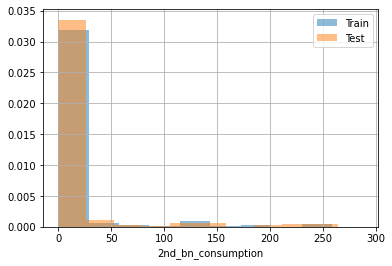

Text(0.5, 0, '2nd_bn_pcs')

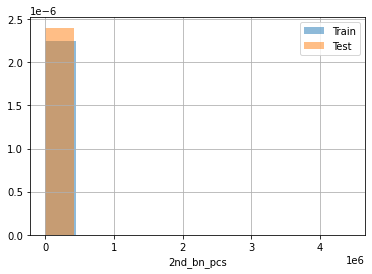

Text(0.5, 0, '3rd_bn_utilization')

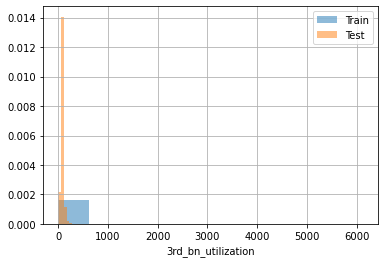

Text(0.5, 0, '3rd_bn_consumption')

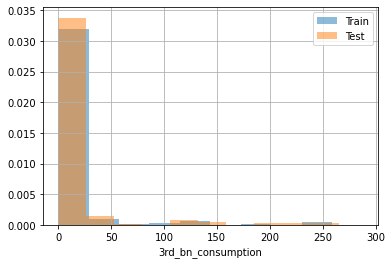

Text(0.5, 0, '3rd_bn_pcs')

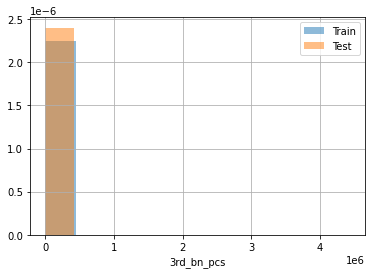

Text(0.5, 0, 'delta_or_demand_request_qty')

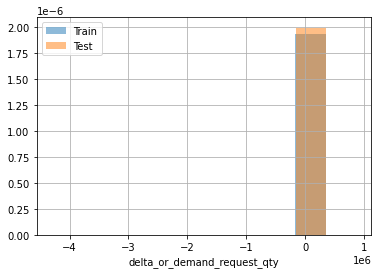

Text(0.5, 0, 'delta_or_derived_demand_request_qty')

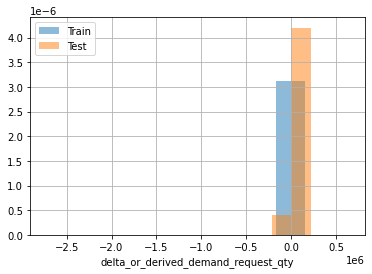

Text(0.5, 0, 'delta_or_total_demand_request_qty')

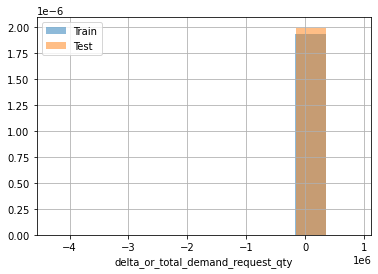

Text(0.5, 0, 'delta_ordergroupsum')

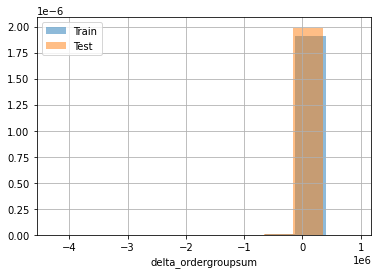

Text(0.5, 0, 'delta_ordergroupsum_percent')

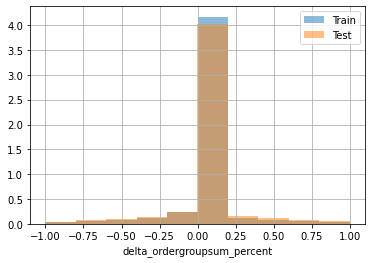

Text(0.5, 0, 'delta_de_disaggregated_quantity')

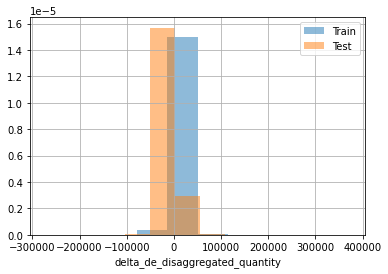

Text(0.5, 0, 'delta_co_customer_order_qty_rmad')

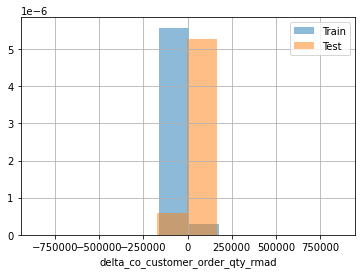

Text(0.5, 0, 'delta_co_customer_order_qty_cmad')

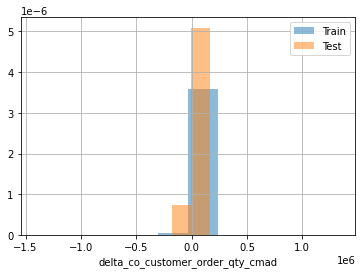

Text(0.5, 0, 'delta_sso_max_stock')

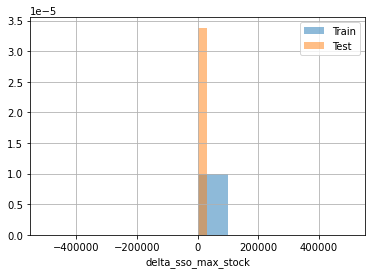

Text(0.5, 0, 'delta_ic_ending_on_hand_inv')

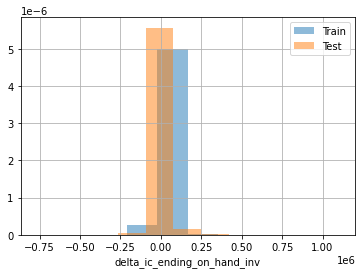

Text(0.5, 0, 'delta_ic_min_target_stock')

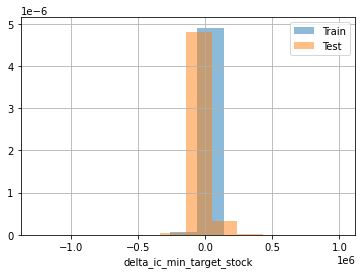

Text(0.5, 0, 'delta_target_delta')

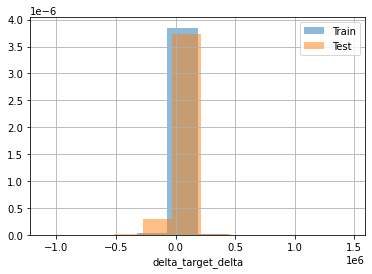

Text(0.5, 0, 'delta_ic_begin_on_hand_inv_first_bkt')

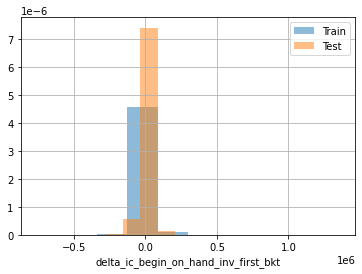

In [24]:
for col in diff_list:    
    df_train.loc[:, col].hist(alpha=0.5, label='Train', density=True)    
    df_test.loc[:, col].hist(alpha=0.5, label='Test', density=True)
    plt.xlabel(col)
    plt.legend()
    plt.show()

### originally: df_train and df_test (this df_test will be treated as validation_set)

df_train is now randomly split to create 30% test called X_test_new and y_test_new (df_test_new)

and df_train_new from X_train_new and y_train_new

we will create 30% sample from df_train_new to do modelling and this will be tested against df_test_new and validated against
df_test

In [95]:
is_demand_reverse = True

target_clf =  ['w0_lateness_increase']
df_train_with_target = df_train[all_features_fields + target_clf]
print("df_train shape to be split into new train and test:", df_train_with_target.shape, df_train.shape)

demand_type_dict = {'SSO_RETAIN_STOCK/EXCESS': 1, 'SSO_SAFETY_STOCK/EXCESS': 2, 'UCO_9991/AP_FCST': 3, 'CO/AP_FCST': 4, 'UCO_9992/AP_FCST': 5, 'AP_FCST/EXCESS': 6, 'CONSI_CO/OP_FCST': 7,
 'CO/OP_FCST': 8, 'UCO_9991/OP_FCST': 9, 'CONSI_UCO_9991/OP_FCST': 10,  'UCO_9992/OP_FCST': 11,  'CO/NP_FCST': 12,  'CONSI_CO/NP_FCST': 13,
 'UCO_9991/NP_FCST': 14, 'CONSI_UCO_9991/NP_FCST': 15, 'UCO_9992/NP_FCST': 16,  'CO_WO_MA/NP_FCST': 17,  'CO/EXCESS': 18, 'UCO_9991/EXCESS': 19,
 'CO_WO_MA/EXCESS': 20, 'UCO_9992/EXCESS': 21,  'CO_WO_MA/OP_FCST': 22,  'CONSI_CO_WO_MA/OP_FCST': 23,  'OP_FCST/EXCESS': 24,
 'SSO_RAMPUP_STOCK/EXCESS': 25,  'CONSI_CO/EXCESS': 26,  'CONSI_CO_WO_MA/NP_FCST': 27,  'CONSI_UCO_9992/NP_FCST': 28,  'SSO_MIN_STOCK/EXCESS': 29,
 'NP_FCST/EXCESS': 30,  'SSO_MAX_STOCK/EXCESS': 31}

if is_demand_reverse:
    df_train_with_target.rename(columns = {'demand_priority': 'demand_priority_old'}, inplace=True)
    df_train_with_target['demand_priority'] = df_train_with_target['demand_type'].map(demand_type_dict)
    df_train_with_target.drop(columns = 'demand_priority_old', inplace=True)
    
y = df_train_with_target[target_clf]
X = df_train_with_target.drop(columns=target_clf)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X,y, test_size = 0.3, random_state = 4)
print("new X_train and X_test:", X_train_new.shape, X_test_new.shape)

df_train_new = pd.concat([X_train_new, y_train_new], axis=1)
df_test_new = pd.concat([X_test_new, y_test_new], axis=1)

print("df_train_new and df_test_new:", df_train_new.shape, df_test_new.shape)

df_train shape to be split into new train and test: (992982, 57) (992982, 63)
new X_train and X_test: (695087, 56) (297895, 56)
df_train_new and df_test_new: (695087, 57) (297895, 57)


In [96]:
X_train_new.set_index(index_columns, inplace=True)
X_test_new.set_index(index_columns, inplace=True)
print("new X_train and X_test:", X_train_new.shape, X_test_new.shape)

new X_train and X_test: (695087, 48) (297895, 48)


In [98]:
X_train_new.demand_priority.unique()

array([ 5.,  8., 30., 13., 17.,  6., 24., 12., 20., 27., 22.,  3., 14.,
       21.,  4., 16., nan,  7., 11.,  9., 15., 23., 10., 18., 19., 28.,
       26.])

### check whether thhis train and test is characteristically similar
### Yes

In [79]:

same_diff_new, same_list_new, diff_list_new = kstest(X_train_new, X_test_new, X_train_new.columns)
same_list_new
diff_list_new

['plan_type_id',
 'demand_priority',
 'demand_type_group_id',
 'or_demand_request_qty',
 'or_derived_demand_request_qty',
 'or_total_demand_request_qty',
 'ordergroupsum',
 'ordergroupsum_percent',
 'de_disaggregated_quantity',
 'co_customer_order_qty_rmad',
 'co_customer_order_qty_cmad',
 'sso_max_stock',
 'sso_min_stock',
 'sso_rampup_stock',
 'sso_retain_stock',
 'sso_safety_stock',
 'ic_ending_on_hand_inv',
 'ic_min_target_stock',
 'target_delta',
 'ic_begin_on_hand_inv_first_bkt',
 'yield',
 '1st_bn_utilization',
 '1st_bn_consumption',
 '1st_bn_pcs',
 '2nd_bn_utilization',
 '2nd_bn_consumption',
 '2nd_bn_pcs',
 '3rd_bn_utilization',
 '3rd_bn_consumption',
 '3rd_bn_pcs',
 'delta_or_demand_request_qty',
 'delta_or_derived_demand_request_qty',
 'delta_or_total_demand_request_qty',
 'delta_ordergroupsum',
 'delta_ordergroupsum_percent',
 'delta_de_disaggregated_quantity',
 'delta_co_customer_order_qty_rmad',
 'delta_co_customer_order_qty_cmad',
 'delta_sso_max_stock',
 'delta_sso_min_

[]

In [80]:
same_diff_new

'same'

Text(0.5, 0, 'plan_type_id')

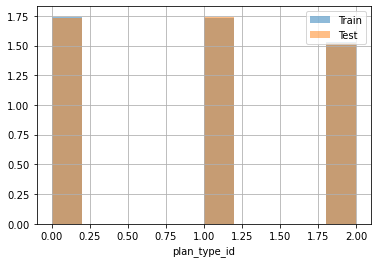

Text(0.5, 0, 'demand_priority')

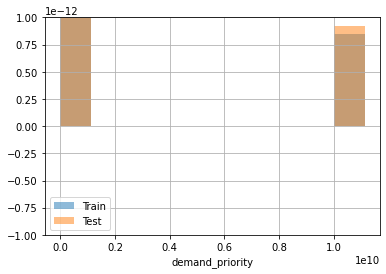

Text(0.5, 0, 'demand_type_group_id')

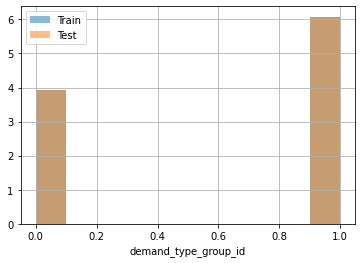

Text(0.5, 0, 'or_demand_request_qty')

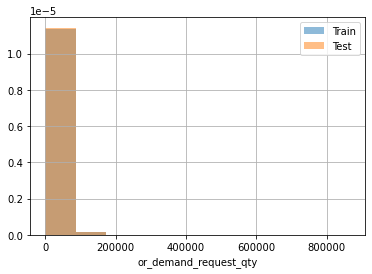

Text(0.5, 0, 'or_derived_demand_request_qty')

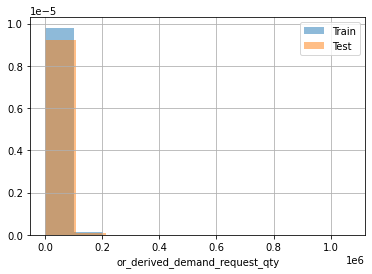

Text(0.5, 0, 'or_total_demand_request_qty')

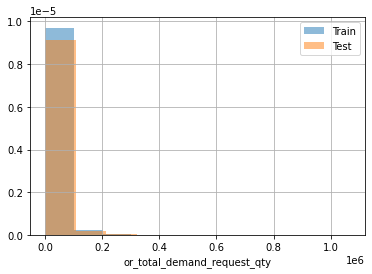

Text(0.5, 0, 'ordergroupsum')

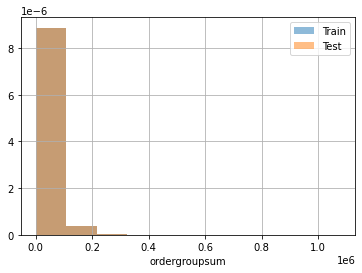

Text(0.5, 0, 'ordergroupsum_percent')

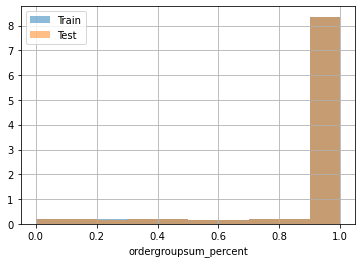

Text(0.5, 0, 'de_disaggregated_quantity')

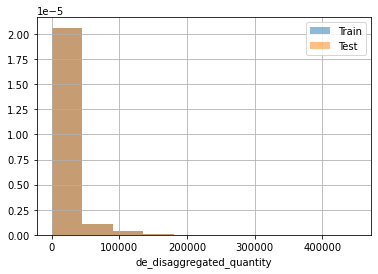

Text(0.5, 0, 'co_customer_order_qty_rmad')

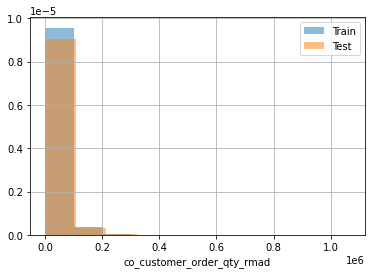

Text(0.5, 0, 'co_customer_order_qty_cmad')

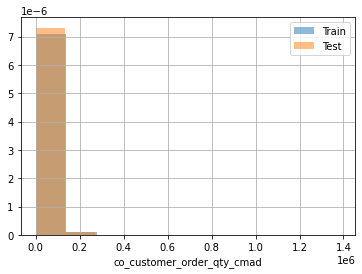

Text(0.5, 0, 'sso_max_stock')

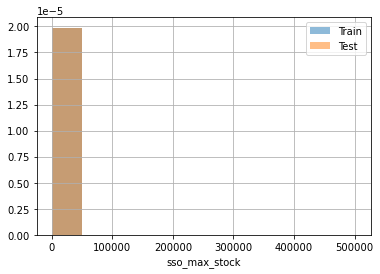

Text(0.5, 0, 'sso_min_stock')

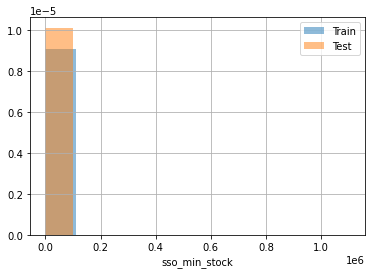

Text(0.5, 0, 'sso_rampup_stock')

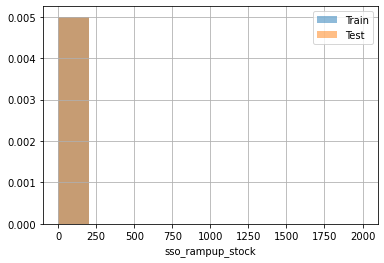

Text(0.5, 0, 'sso_retain_stock')

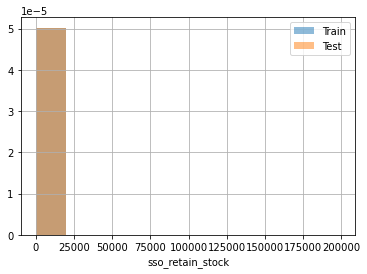

Text(0.5, 0, 'sso_safety_stock')

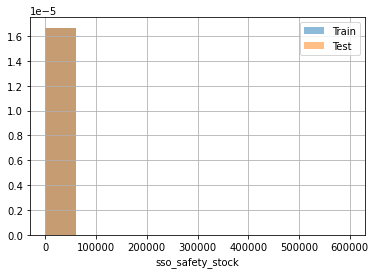

Text(0.5, 0, 'ic_ending_on_hand_inv')

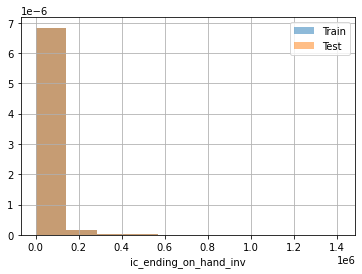

Text(0.5, 0, 'ic_min_target_stock')

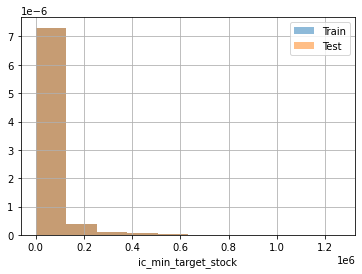

Text(0.5, 0, 'target_delta')

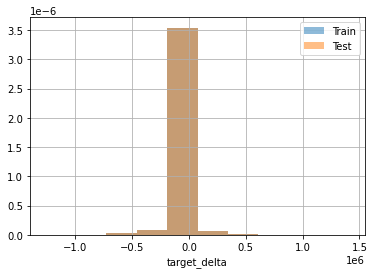

Text(0.5, 0, 'ic_begin_on_hand_inv_first_bkt')

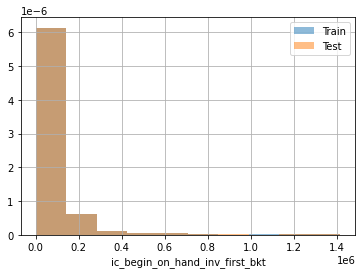

Text(0.5, 0, 'yield')

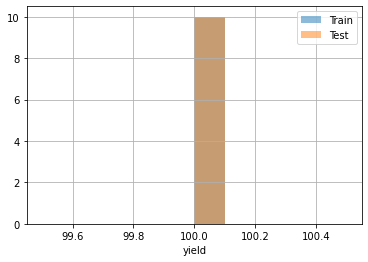

Text(0.5, 0, '1st_bn_utilization')

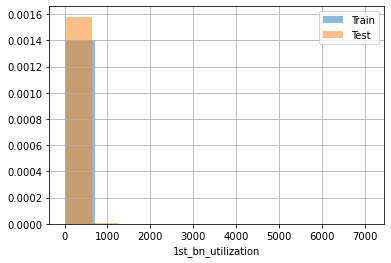

Text(0.5, 0, '1st_bn_consumption')

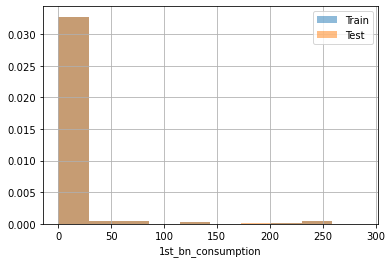

Text(0.5, 0, '1st_bn_pcs')

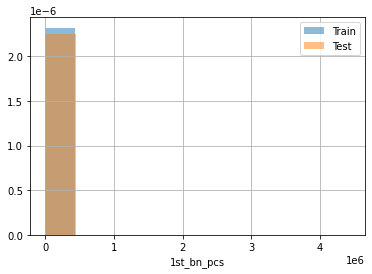

Text(0.5, 0, '2nd_bn_utilization')

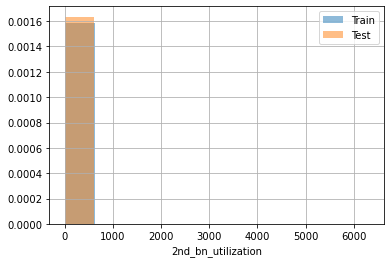

Text(0.5, 0, '2nd_bn_consumption')

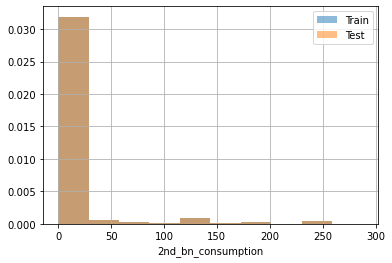

Text(0.5, 0, '2nd_bn_pcs')

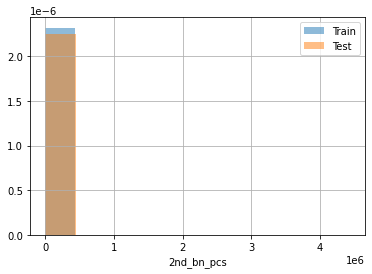

Text(0.5, 0, '3rd_bn_utilization')

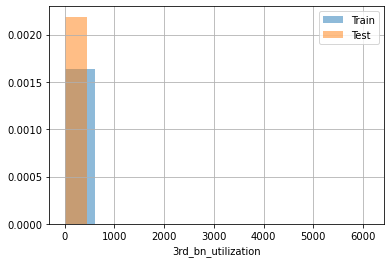

Text(0.5, 0, '3rd_bn_consumption')

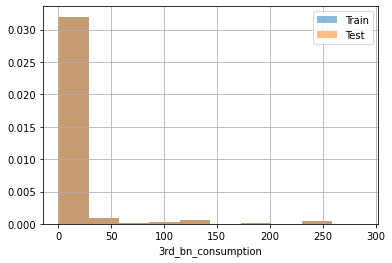

Text(0.5, 0, '3rd_bn_pcs')

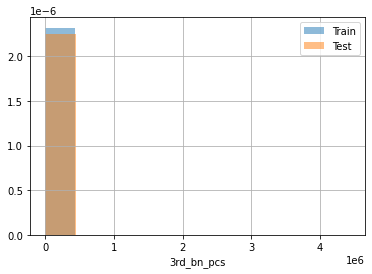

Text(0.5, 0, 'delta_or_demand_request_qty')

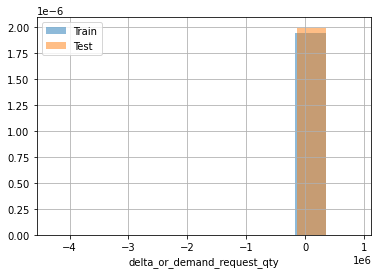

Text(0.5, 0, 'delta_or_derived_demand_request_qty')

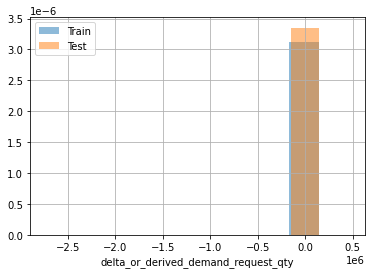

Text(0.5, 0, 'delta_or_total_demand_request_qty')

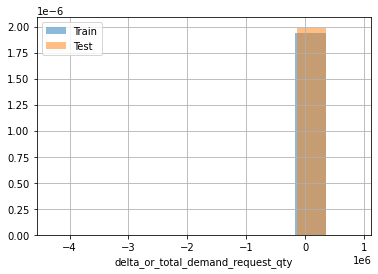

Text(0.5, 0, 'delta_ordergroupsum')

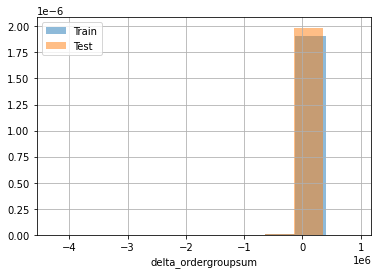

Text(0.5, 0, 'delta_ordergroupsum_percent')

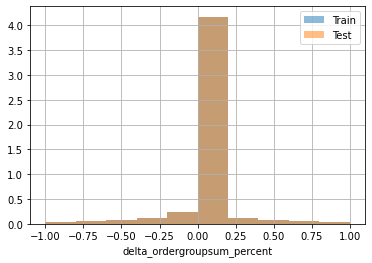

Text(0.5, 0, 'delta_de_disaggregated_quantity')

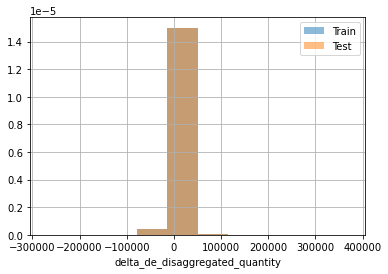

Text(0.5, 0, 'delta_co_customer_order_qty_rmad')

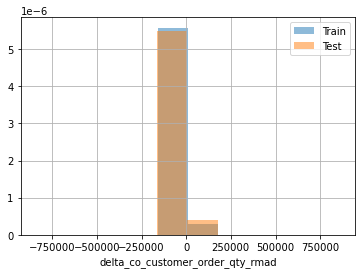

Text(0.5, 0, 'delta_co_customer_order_qty_cmad')

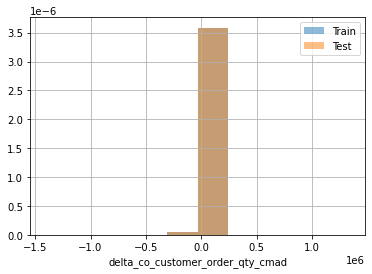

Text(0.5, 0, 'delta_sso_max_stock')

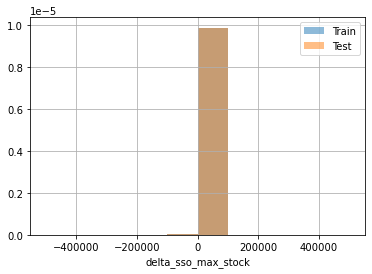

Text(0.5, 0, 'delta_sso_min_stock')

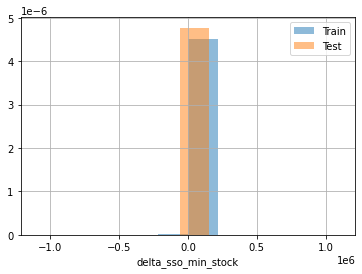

Text(0.5, 0, 'delta_sso_rampup_stock')

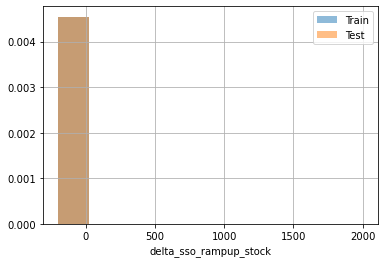

Text(0.5, 0, 'delta_sso_retain_stock')

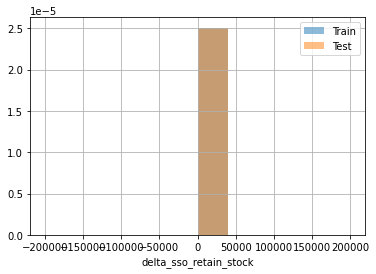

Text(0.5, 0, 'delta_sso_safety_stock')

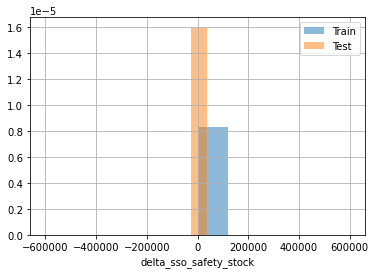

Text(0.5, 0, 'delta_ic_ending_on_hand_inv')

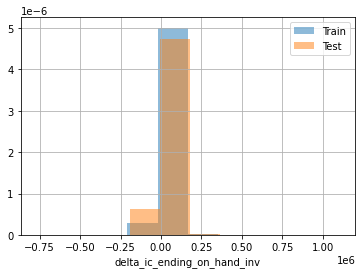

Text(0.5, 0, 'delta_ic_min_target_stock')

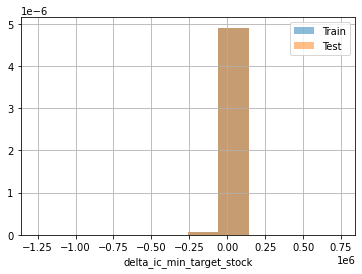

Text(0.5, 0, 'delta_target_delta')

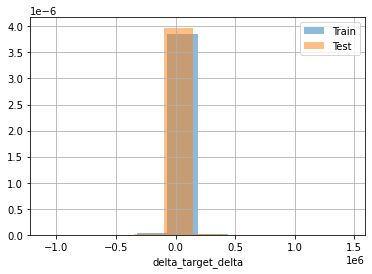

Text(0.5, 0, 'delta_ic_begin_on_hand_inv_first_bkt')

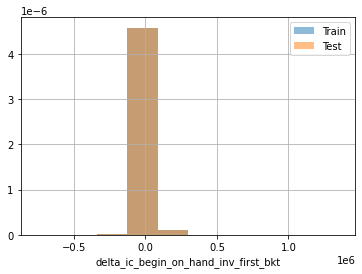

Text(0.5, 0, 'delta_yield')

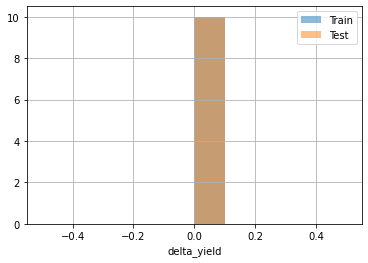

In [32]:
for col in same_list_new:    
    X_train_new.loc[:, col].hist(alpha=0.5, label='Train', density=True)    
    X_test_new.loc[:, col].hist(alpha=0.5, label='Test', density=True)
    plt.xlabel(col)
    plt.legend()
    plt.show()

In [33]:
for col in diff_list_new:    
    X_train_new.loc[:, col].hist(alpha=0.5, label='Train', density=True)    
    X_test_new.loc[:, col].hist(alpha=0.5, label='Test', density=True)
    plt.xlabel(col)
    plt.legend()
    plt.show()

In [99]:
model_new = xgb.XGBClassifier(scale_pos_weight = scaled_weight, seed=42)
model_new.fit(X_train_new, y_train_new)
y_pred_train_new = model_new.predict(X_train_new)
y_pred_test_new = model_new.predict(X_test_new)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=6.085693490034894,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [94]:
pickle.dump(model_new, open('../../models/2020-11-10/' + 'xgb_best_driftless.dat', 'wb'))

In [100]:
y_test_pred_clf_proba = model_new.predict_proba(X_test_new)
y_train_pred_clf_proba = model_new.predict_proba(X_train_new)


print("Avg precision train:", average_precision_score(y_train_new, y_train_pred_clf_proba[:,1]))
print("Avg precision test:", average_precision_score(y_test_new, y_test_pred_clf_proba[:,1]))
print("Precision train:", precision_score(y_train_new, y_pred_train_new))
print("Precision test:", precision_score(y_test_new, y_pred_test_new))
print("Recall train:", recall_score(y_train_new, y_pred_train_new))
print("Recall test:", recall_score(y_test_new, y_pred_test_new))
print("F1 train:", f1_score(y_train_new, y_pred_train_new))
print("F1 test:", f1_score(y_test_new, y_pred_test_new))

Avg precision train: 0.8150862919303775
Avg precision test: 0.7973260731557361
Precision train: 0.5487406508273683
Precision test: 0.5405092107652127
Recall train: 0.9390579178885631
Recall test: 0.9229686866518805
F1 train: 0.6927002940613135
F1 test: 0.6817637318112955


In [101]:
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test_new, y_test_pred_clf_proba[:,1])
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train_new, y_train_pred_clf_proba[:,1])

precision_recall_thresholds_test_df = pd.DataFrame.from_records([x for x in zip(precision_test, recall_test, \
                                    list(thresholds_test)+[0])], columns = ['Precision', 'Recall', 'Threshold'])

precision_recall_thresholds_train_df = pd.DataFrame.from_records([x for x in zip(precision_train, recall_train, \
                                            list(thresholds_train)+[0])], columns = ['Precision', 'Recall', 'Threshold'])

In [102]:
precision_recall_thresholds_train_df[precision_recall_thresholds_train_df.Precision > precision_recall_thresholds_train_df.Recall]

,Precision,Recall,Threshold
400885,0.745375,0.745367,0.797519
400886,0.745382,0.745367,0.797544
400887,0.745380,0.745357,0.797544
400888,0.745387,0.745357,0.797550
400889,0.745385,0.745347,0.797552
...,...,...,...
450304,1.000000,0.000041,0.999363
450305,1.000000,0.000031,0.999450
450306,1.000000,0.000020,0.999498
450307,1.000000,0.000010,0.999689


In [103]:
precision_recall_thresholds_test_df[precision_recall_thresholds_test_df.Precision > precision_recall_thresholds_test_df.Recall]

,Precision,Recall,Threshold
194548,0.733794,0.733777,0.796685
194549,0.733782,0.733729,0.796687
194550,0.733799,0.733729,0.796688
194551,0.733852,0.733729,0.796698
194552,0.733869,0.733729,0.796701
...,...,...,...
219528,1.000000,0.000095,0.998935
219529,1.000000,0.000072,0.999025
219530,1.000000,0.000048,0.999033
219531,1.000000,0.000024,0.999754


In [104]:
print("train cut off:", 0.797)
cut_off = 0.796
y_pred_train_cutoff = np.where(y_train_pred_clf_proba[:,1] > cut_off, 1, 0)
y_pred_test_cutoff = np.where(y_test_pred_clf_proba[:,1] > cut_off, 1, 0)

precision_score(y_train_new, y_pred_train_cutoff), precision_score(y_test_new, y_pred_test_cutoff)
recall_score(y_train_new, y_pred_train_cutoff), recall_score(y_test_new, y_pred_test_cutoff)
f1_score(y_train_new, y_pred_train_cutoff), f1_score(y_test_new, y_pred_test_cutoff)

train cut off: 0.797


(0.7438362269808149, 0.7332349721574414)

(0.7477293092212447, 0.7348262621926498)

(0.7457776875031736, 0.7340297547437257)

### Using best model till now to check the results on original train and test

In [87]:
y_test_pred_new = model_new.predict(X_test)
y_train_pred_new = model_new.predict(X_train)
precision_score(y_train, y_train_pred_new), precision_score(y_test, y_test_pred_new)
recall_score(y_train, y_train_pred_new), recall_score(y_test, y_test_pred_new)
f1_score(y_train, y_train_pred_new), f1_score(y_test, y_test_pred_new)

(0.5577221563619031, 0.4622186702415633)

(0.6512748057285981, 0.5245465184318315)

(0.6008789110719752, 0.49141416217845935)

In [88]:
y_test_pred_clf_proba = model_new.predict_proba(X_test)
y_train_pred_clf_proba = model_new.predict_proba(X_train)


print("Avg precision train:", average_precision_score(y_train, y_train_pred_clf_proba[:,1]))
print("Avg precision test:", average_precision_score(y_test, y_test_pred_clf_proba[:,1]))

Avg precision train: 0.5949196206771733
Avg precision test: 0.43573384376280844


In [89]:
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_test_pred_clf_proba[:,1])
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_pred_clf_proba[:,1])

precision_recall_thresholds_test_df = pd.DataFrame.from_records([x for x in zip(precision_test, recall_test, \
                                    list(thresholds_test)+[0])], columns = ['Precision', 'Recall', 'Threshold'])

precision_recall_thresholds_train_df = pd.DataFrame.from_records([x for x in zip(precision_train, recall_train, \
                                            list(thresholds_train)+[0])], columns = ['Precision', 'Recall', 'Threshold'])

In [90]:
precision_recall_thresholds_train_df[precision_recall_thresholds_train_df.Precision > precision_recall_thresholds_train_df.Recall]

,Precision,Recall,Threshold
714492,0.588163,0.588159,0.566122
714493,0.588167,0.588159,0.566127
714494,0.588164,0.588152,0.566131
714495,0.588169,0.588152,0.566142
714496,0.588173,0.588152,0.566157
...,...,...,...
793822,1.000000,0.000029,0.999207
793823,1.000000,0.000021,0.999314
793824,1.000000,0.000014,0.999714
793825,1.000000,0.000007,0.999778


In [91]:
precision_recall_thresholds_test_df[precision_recall_thresholds_test_df.Precision > precision_recall_thresholds_test_df.Recall]

,Precision,Recall,Threshold
172922,0.477194,0.477180,0.550339
172923,0.477208,0.477180,0.550362
172924,0.477277,0.477180,0.550388
172925,0.477291,0.477180,0.550389
172926,0.477305,0.477180,0.550416
...,...,...,...
194344,1.000000,0.000117,0.997068
194345,1.000000,0.000088,0.997164
194346,1.000000,0.000059,0.998943
194347,1.000000,0.000029,0.999055


In [92]:
print("train cut off:", 0.56)
cut_off = 0.56
y_pred_train_cutoff = np.where(y_train_pred_clf_proba[:,1] > cut_off, 1, 0)
y_pred_test_cutoff = np.where(y_test_pred_clf_proba[:,1] > cut_off, 1, 0)

precision_score(y_train, y_pred_train_cutoff), precision_score(y_test, y_pred_test_cutoff)
recall_score(y_train, y_pred_train_cutoff), recall_score(y_test, y_pred_test_cutoff)
f1_score(y_train, y_pred_train_cutoff), f1_score(y_test, y_pred_test_cutoff)

train cut off: 0.56


(0.5858656797129032, 0.4811249812001805)

(0.5952804001741129, 0.4679637214745465)

(0.5905355183520333, 0.47445309603262886)

### End of experiment

#### Feature importance of best model

In [42]:
feat_array = model_new.feature_importances_

df_feat = pd.DataFrame()
name_list, importance_list = [], []
for name, importance in zip((X_train_new.columns), feat_array):
    name_list.append(name)
    importance_list.append(importance)
df_feat['name'] = name_list
df_feat['importance'] = importance_list

In [44]:
df_feat.sort_values(by='importance', ascending=False)

,name,importance
10,co_customer_order_qty_cmad,0.250933
0,plan_type_id,0.064996
1,demand_priority,0.056467
24,2nd_bn_utilization,0.050926
39,delta_sso_min_stock,0.042927
26,2nd_bn_pcs,0.036029
41,delta_sso_retain_stock,0.034229
18,target_delta,0.031408
16,ic_ending_on_hand_inv,0.030557
38,delta_sso_max_stock,0.029180


### check the distributions of new train and test

Text(0.5, 0, 'plan_type_id')

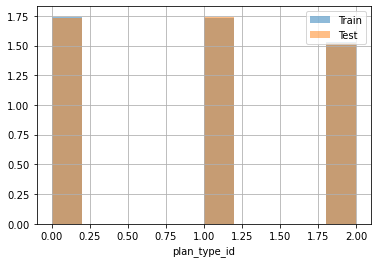

Text(0.5, 0, 'demand_priority')

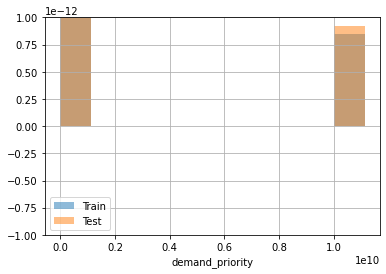

Text(0.5, 0, 'demand_type_group_id')

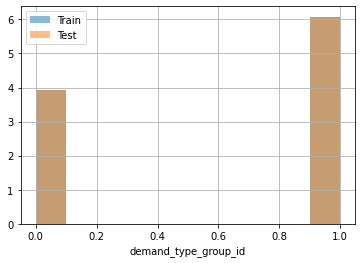

Text(0.5, 0, 'or_demand_request_qty')

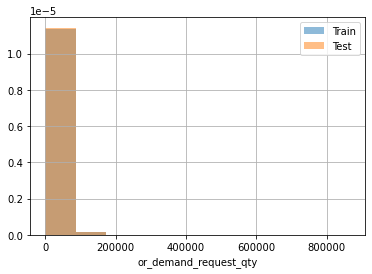

Text(0.5, 0, 'or_derived_demand_request_qty')

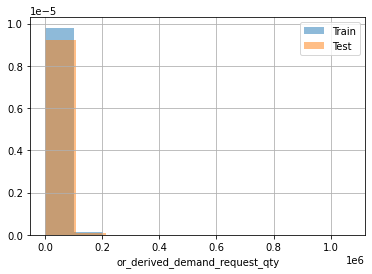

Text(0.5, 0, 'or_total_demand_request_qty')

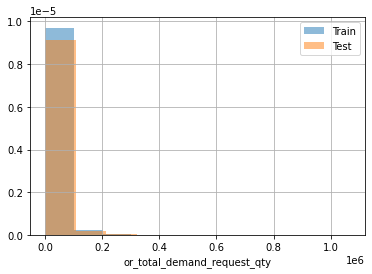

Text(0.5, 0, 'ordergroupsum')

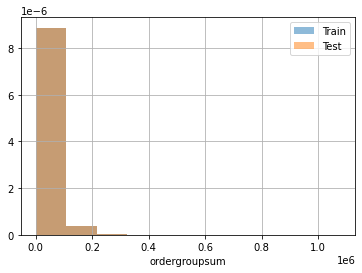

Text(0.5, 0, 'ordergroupsum_percent')

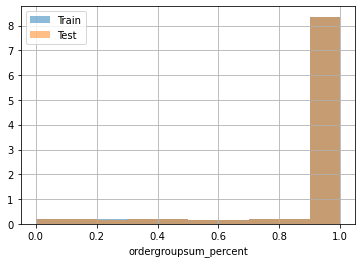

Text(0.5, 0, 'de_disaggregated_quantity')

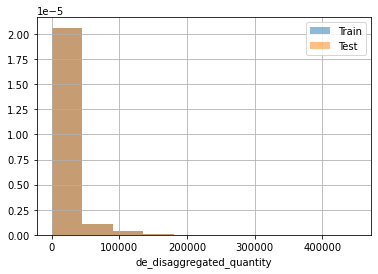

Text(0.5, 0, 'co_customer_order_qty_rmad')

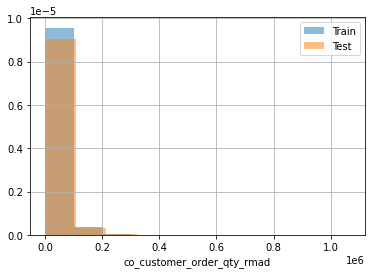

Text(0.5, 0, 'co_customer_order_qty_cmad')

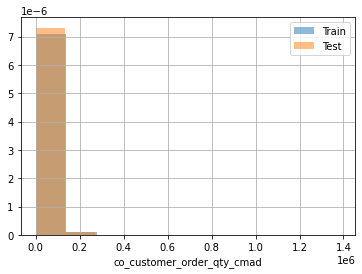

Text(0.5, 0, 'sso_max_stock')

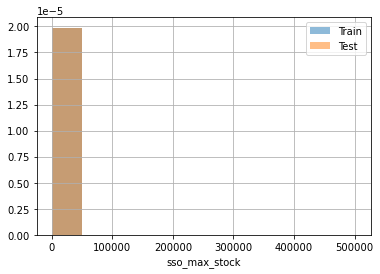

Text(0.5, 0, 'sso_min_stock')

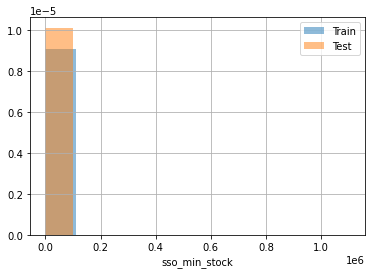

Text(0.5, 0, 'sso_rampup_stock')

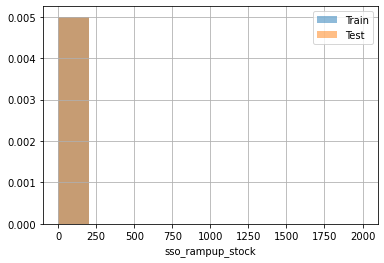

Text(0.5, 0, 'sso_retain_stock')

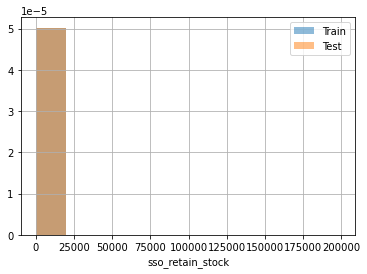

Text(0.5, 0, 'sso_safety_stock')

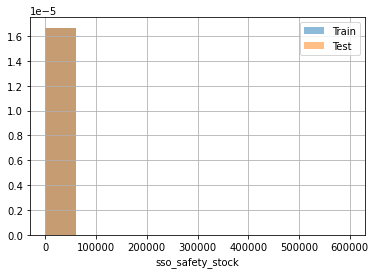

Text(0.5, 0, 'ic_ending_on_hand_inv')

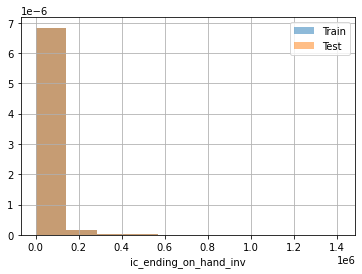

Text(0.5, 0, 'ic_min_target_stock')

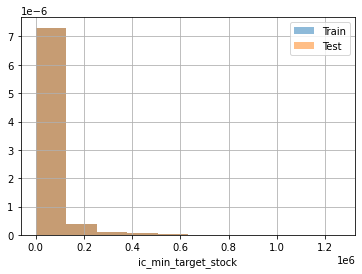

Text(0.5, 0, 'target_delta')

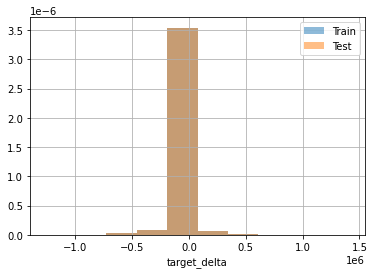

Text(0.5, 0, 'ic_begin_on_hand_inv_first_bkt')

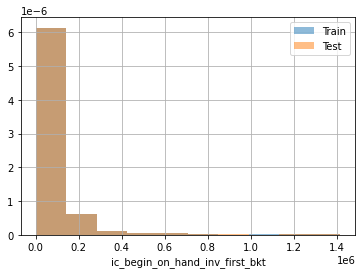

Text(0.5, 0, 'yield')

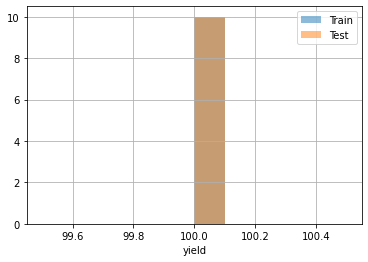

Text(0.5, 0, '1st_bn_utilization')

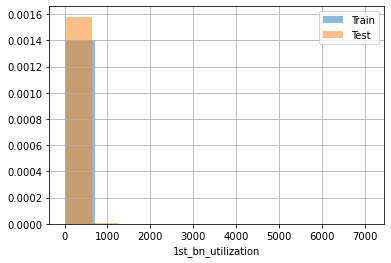

Text(0.5, 0, '1st_bn_consumption')

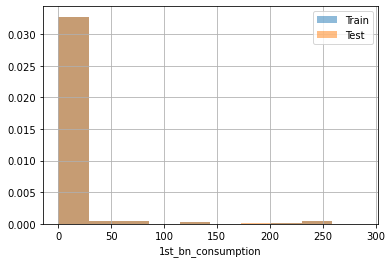

Text(0.5, 0, '1st_bn_pcs')

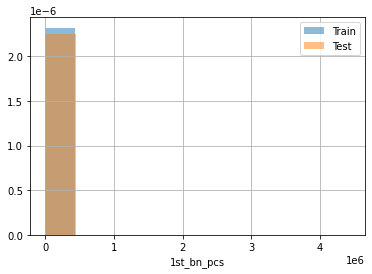

Text(0.5, 0, '2nd_bn_utilization')

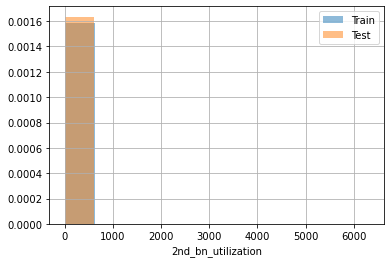

Text(0.5, 0, '2nd_bn_consumption')

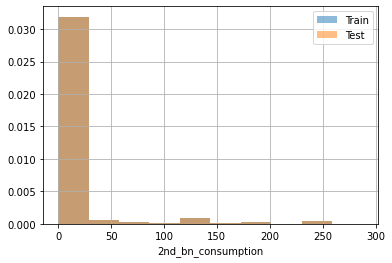

Text(0.5, 0, '2nd_bn_pcs')

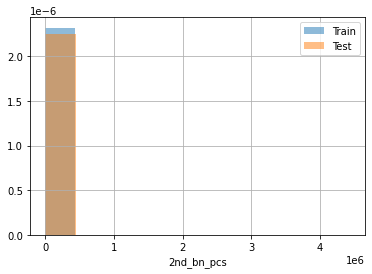

Text(0.5, 0, '3rd_bn_utilization')

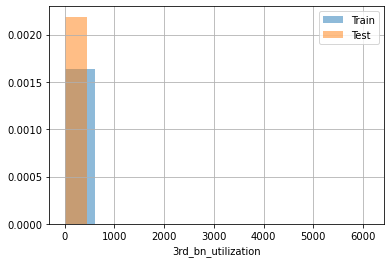

Text(0.5, 0, '3rd_bn_consumption')

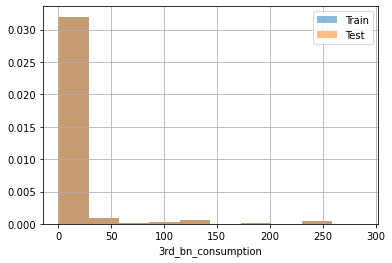

Text(0.5, 0, '3rd_bn_pcs')

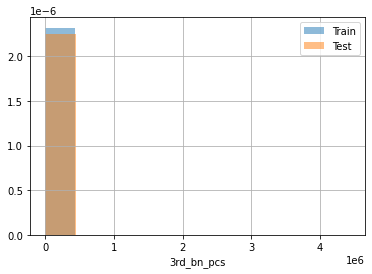

Text(0.5, 0, 'delta_or_demand_request_qty')

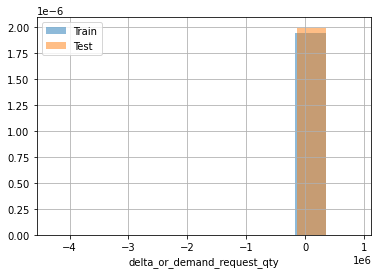

Text(0.5, 0, 'delta_or_derived_demand_request_qty')

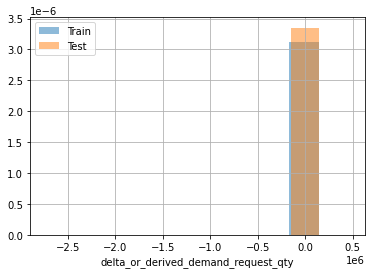

Text(0.5, 0, 'delta_or_total_demand_request_qty')

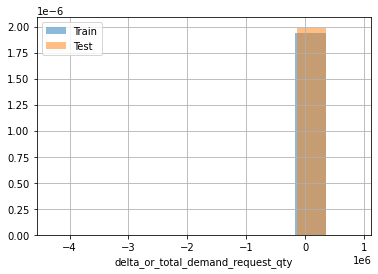

Text(0.5, 0, 'delta_ordergroupsum')

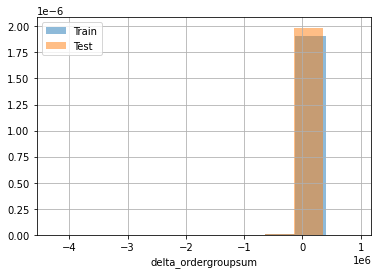

Text(0.5, 0, 'delta_ordergroupsum_percent')

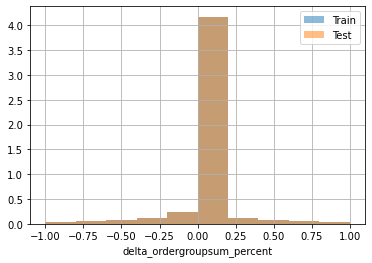

Text(0.5, 0, 'delta_de_disaggregated_quantity')

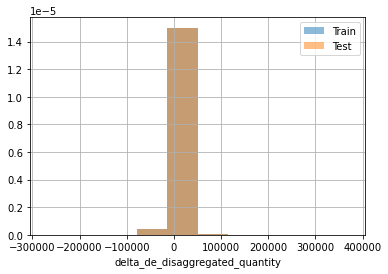

Text(0.5, 0, 'delta_co_customer_order_qty_rmad')

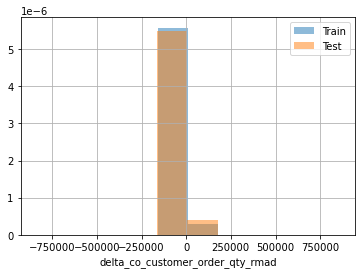

Text(0.5, 0, 'delta_co_customer_order_qty_cmad')

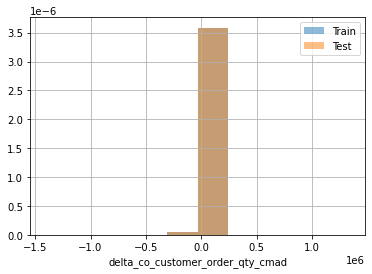

Text(0.5, 0, 'delta_sso_max_stock')

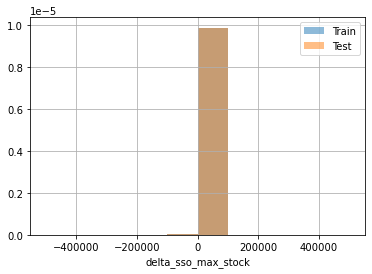

Text(0.5, 0, 'delta_sso_min_stock')

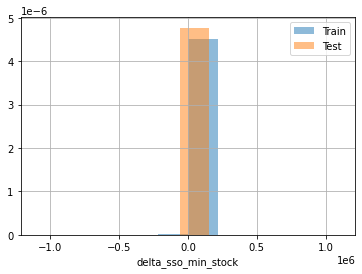

Text(0.5, 0, 'delta_sso_rampup_stock')

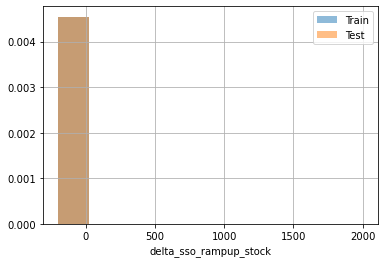

Text(0.5, 0, 'delta_sso_retain_stock')

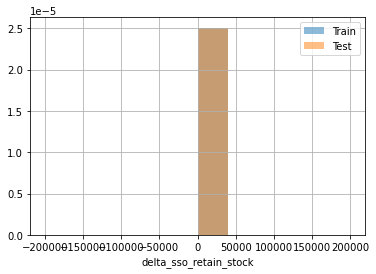

Text(0.5, 0, 'delta_sso_safety_stock')

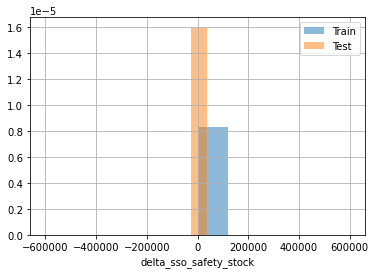

Text(0.5, 0, 'delta_ic_ending_on_hand_inv')

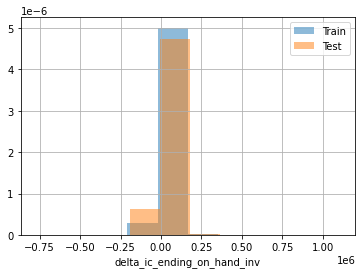

Text(0.5, 0, 'delta_ic_min_target_stock')

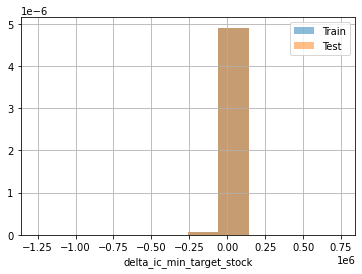

Text(0.5, 0, 'delta_target_delta')

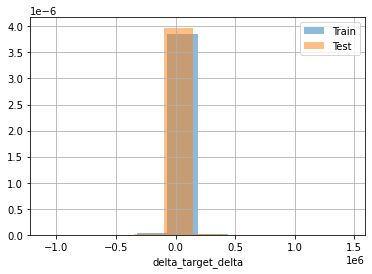

Text(0.5, 0, 'delta_ic_begin_on_hand_inv_first_bkt')

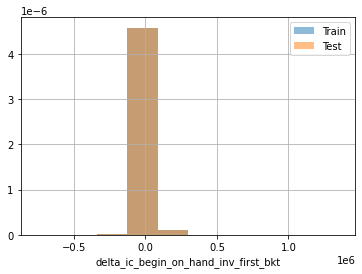

Text(0.5, 0, 'delta_yield')

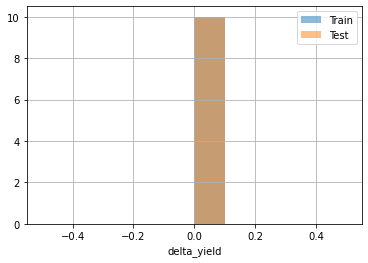

In [45]:
for col in X_train_new.columns:    
    X_train_new.loc[:, col].hist(alpha=0.5, label='Train', density=True)    
    X_test_new.loc[:, col].hist(alpha=0.5, label='Test', density=True)
    plt.xlabel(col)
    plt.legend()
    plt.show()

In [46]:
### experimental checking whether x_train_new which is sampled from df_train is similar to X_test
same_diff_newtrain_test, _, _ = kstest(X_train_new, X_test.reset_index(), X_train_new.columns)
same_diff_newtrain_test

'different'

In [47]:
### experimental checking whether x_train_new which is sampled from df_train is similar to X_train
same_diff_new, _, _ = kstest(X_train_new, X_train.reset_index(), X_train_new.columns)

In [48]:
same_diff_new

'same'

In [50]:
df_train_with_target.shape

(992982, 57)

In [52]:
df_train_with_target.run_time_date.min(), df_train_with_target.run_time_date.max()

('2020-01-11', '2020-07-04')

In [53]:
np.sort(df_train_with_target.run_time_date.unique())

array(['2020-01-11', '2020-01-25', '2020-02-01', '2020-02-08',
       '2020-02-15', '2020-02-22', '2020-02-29', '2020-03-07',
       '2020-03-14', '2020-03-21', '2020-03-28', '2020-04-04',
       '2020-04-11', '2020-04-18', '2020-04-25', '2020-05-02',
       '2020-05-09', '2020-05-16', '2020-05-23', '2020-05-30',
       '2020-06-06', '2020-06-13', '2020-06-20', '2020-06-27',
       '2020-07-04'], dtype=object)

In [54]:
df_train_1306 = df_train_with_target[df_train_with_target.run_time_date < '2020-06-13']
df_train_1306.shape

(820548, 57)

In [55]:
df_test_1306 = df_train_with_target[df_train_with_target.run_time_date >= '2020-06-13']
df_test_1306.shape

(172434, 57)

In [56]:
df_test_1306.run_time_date.unique()

array(['2020-06-13', '2020-06-20', '2020-06-27', '2020-07-04'],
      dtype=object)

In [57]:
X_train_1306 = df_train_1306[all_features_fields]
X_test_1306 = df_test_1306[all_features_fields]

X_train_1306 = X_train_1306.set_index(index_columns)
X_test_1306 = X_test_1306.set_index(index_columns)

y_train_1306 = df_train_1306[target_clf]
y_test_1306 = df_test_1306[target_clf]

In [69]:
model_1306 = xgb.XGBClassifier(scale_pos_weight = scaled_weight, seed=42)
model_1306.fit(X_train_1306, y_train_1306)
y_pred_train_1306 = model_1306.predict(X_train_1306)
y_pred_test_1306 = model_1306.predict(X_test_1306)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=6.085693490034894,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [70]:
y_test_pred_clf_proba_1306 = model_1306.predict_proba(X_test_1306)
y_train_pred_clf_proba_1306 = model_1306.predict_proba(X_train_1306)


print("Avg precision train:", average_precision_score(y_train_1306, y_train_pred_clf_proba_1306[:,1]))
print("Avg precision test:", average_precision_score(y_test_1306, y_test_pred_clf_proba_1306[:,1]))
print("Precision train:", precision_score(y_train_1306, y_pred_train_1306))
print("Precision test:", precision_score(y_test_1306, y_pred_test_1306))
print("Recall train:", recall_score(y_train_1306, y_pred_train_1306))
print("Recall test:", recall_score(y_test_1306, y_pred_test_1306))
print("F1 train:", f1_score(y_train_1306, y_pred_train_1306))
print("F1 test:", f1_score(y_test_1306, y_pred_test_1306))

Avg precision train: 0.8160261695662328
Avg precision test: 0.6934520350105569
Precision train: 0.5534212229052087
Precision test: 0.525877707822004
Recall train: 0.9378105191022785
Recall test: 0.8424291636394717
F1 train: 0.6960745667018476
F1 test: 0.6475370793160652


In [71]:
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test_1306, y_test_pred_clf_proba_1306[:,1])
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train_1306, y_train_pred_clf_proba_1306[:,1])

precision_recall_thresholds_test_df = pd.DataFrame.from_records([x for x in zip(precision_test, recall_test, \
                                    list(thresholds_test)+[0])], columns = ['Precision', 'Recall', 'Threshold'])

precision_recall_thresholds_train_df = pd.DataFrame.from_records([x for x in zip(precision_train, recall_train, \
                                            list(thresholds_train)+[0])], columns = ['Precision', 'Recall', 'Threshold'])

In [74]:
precision_recall_thresholds_train_df[precision_recall_thresholds_train_df.Precision > precision_recall_thresholds_train_df.Recall]

,Precision,Recall,Threshold
462492,0.747591,0.747584,0.795836
462493,0.747589,0.747576,0.795839
462494,0.747586,0.747567,0.795842
462495,0.747584,0.747559,0.795861
462496,0.747591,0.747559,0.795862
...,...,...,...
517208,1.000000,0.000034,0.999501
517209,1.000000,0.000026,0.999726
517210,1.000000,0.000017,0.999800
517211,1.000000,0.000009,0.999854


In [75]:
precision_recall_thresholds_test_df[precision_recall_thresholds_test_df.Precision > precision_recall_thresholds_test_df.Recall]

,Precision,Recall,Threshold
107284,0.649089,0.648617,0.745252
107285,0.649117,0.648617,0.745263
107286,0.649102,0.648575,0.745303
107287,0.649087,0.648532,0.745346
107288,0.649115,0.648532,0.745398
...,...,...,...
118538,1.000000,0.000171,0.999434
118539,1.000000,0.000128,0.999456
118540,1.000000,0.000085,0.999473
118541,1.000000,0.000043,0.999628


In [76]:
print("train cut off:", 0.795)
cut_off = 0.796
y_pred_train_cutoff = np.where(y_train_pred_clf_proba_1306[:,1] > cut_off, 1, 0)
y_pred_test_cutoff = np.where(y_test_pred_clf_proba_1306[:,1] > cut_off, 1, 0)

precision_score(y_train_1306, y_pred_train_cutoff), precision_score(y_test_1306, y_pred_test_cutoff)
recall_score(y_train_1306, y_pred_train_cutoff), recall_score(y_test_1306, y_pred_test_cutoff)
f1_score(y_train_1306, y_pred_train_cutoff), f1_score(y_test_1306, y_pred_test_cutoff)

train cut off: 0.795


(0.747784576884181, 0.6860636192988686)

(0.747413054651362, 0.5779306807983248)

(0.7475987696104052, 0.627371839480399)

In [49]:
df_train_with_target.head()

,item_name,item_pl_name,demand_type,demand_type_group,demand_type_parent,plan_type,requested_delivery_week,run_time_date,plan_type_id,demand_priority,demand_type_group_id,or_demand_request_qty,or_derived_demand_request_qty,or_total_demand_request_qty,ordergroupsum,ordergroupsum_percent,de_disaggregated_quantity,co_customer_order_qty_rmad,co_customer_order_qty_cmad,sso_max_stock,sso_min_stock,sso_rampup_stock,sso_retain_stock,sso_safety_stock,ic_ending_on_hand_inv,ic_min_target_stock,target_delta,ic_begin_on_hand_inv_first_bkt,yield,1st_bn_utilization,1st_bn_consumption,1st_bn_pcs,2nd_bn_utilization,2nd_bn_consumption,2nd_bn_pcs,3rd_bn_utilization,3rd_bn_consumption,3rd_bn_pcs,delta_or_demand_request_qty,delta_or_derived_demand_request_qty,delta_or_total_demand_request_qty,delta_ordergroupsum,delta_ordergroupsum_percent,delta_de_disaggregated_quantity,delta_co_customer_order_qty_rmad,delta_co_customer_order_qty_cmad,delta_sso_max_stock,delta_sso_min_stock,delta_sso_rampup_stock,delta_sso_retain_stock,delta_sso_safety_stock,delta_ic_ending_on_hand_inv,delta_ic_min_target_stock,delta_target_delta,delta_ic_begin_on_hand_inv_first_bkt,delta_yield,w0_lateness_increase
0,VKL_DCA_99400558,26,CO/NP_FCST,ORDERS,CO,DM_PLAN_CONS,202015,2020-01-11,0,2524927.0,1,0.0,10000.0,10000.0,12500.0,0.8,NaN,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,60000.0,0.0,60000.0,72500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2500.0,-0.2,NaN,0.0,0.0,-10222.0,-35778.0,0.0,0.0,0.0,-12500.0,-46000.0,33500.0,-10000.0,NaN,0.0
1,VKL_DCA_99400558,26,CO/NP_FCST,ORDERS,CO,DM_PLAN_CONS,202016,2020-01-11,0,2524927.0,1,0.0,15000.0,15000.0,15000.0,1.0,17111.0,15000.0,15000.0,9000.0,31500.0,0.0,0.0,0.0,45000.0,40500.0,4500.0,72500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-2500.0,-2500.0,-2500.0,0.0,542.0,-2500.0,-2500.0,9000.0,31500.0,0.0,0.0,0.0,-10000.0,-5500.0,-4500.0,-10000.0,NaN,0.0
2,VKL_DCA_99400558,26,CO/NP_FCST,ORDERS,CO,DM_PLAN_CONS,202017,2020-01-11,0,2524927.0,1,0.0,22500.0,22500.0,22500.0,1.0,17111.0,22500.0,22500.0,0.0,0.0,0.0,0.0,0.0,22500.0,40500.0,-18000.0,72500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-2500.0,-2500.0,-2500.0,0.0,542.0,-2500.0,-2500.0,0.0,0.0,0.0,0.0,0.0,-7500.0,-5500.0,-2000.0,-10000.0,NaN,0.0
3,VKL_DCA_99400558,26,CO/NP_FCST,ORDERS,CO,DM_PLAN_CONS,202018,2020-02-01,0,2524927.0,1,0.0,5000.0,5000.0,5000.0,1.0,NaN,5000.0,5000.0,0.0,0.0,0.0,0.0,0.0,27500.0,0.0,27500.0,32500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-5000.0,-5000.0,-5000.0,0.0,NaN,-5000.0,-5000.0,-7333.0,-25667.0,0.0,0.0,0.0,0.0,-33000.0,33000.0,-5000.0,NaN,0.0
4,VKL_DCA_99400558,26,CO/NP_FCST,ORDERS,CO,DM_PLAN_CONS,202019,2020-01-11,0,2524927.0,1,0.0,12500.0,12500.0,12500.0,1.0,12500.0,12500.0,12500.0,0.0,0.0,0.0,0.0,0.0,10000.0,40500.0,-30500.0,72500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-2500.0,-2500.0,-2500.0,0.0,-4069.0,-2500.0,-2500.0,0.0,0.0,0.0,0.0,0.0,-5000.0,-5500.0,500.0,-10000.0,NaN,0.0


### take sample first from entire data, will later check on no NA data prepared above
will check the model trained on both data and check on test on 2 criteria -- random or time cut off (if previous step 
suggests that train and test are same over time)

##### take 30% sample from X_train_new 

In [175]:
def sample_and_test(df, fra, pnum_l):
    x = True
    count = 0
    while (x):
        count=count+1
        print(count)
        seed = random.randint(1,100)
        df_sample = df.sample(frac = fra, random_state=seed)
        print("##################Numerical features K-S test###########################################")
        if kstest(df_sample, df, numeric_cols) == 'same':
            x = False
            print("Inside if")
    return df_sample
# for i in [0.3, 0.4, 0.5]:
df_sample = sample_and_test(df_train_new, 0.3, 0.5)

1
##################Numerical features K-S test###########################################
Inside if


##### check if random 30% sample from df_train_new is similar:

In [176]:
kstest(df_sample, df_train_new, df_train_new.columns)

'same'

In [177]:
print("sampled from df_train_new:", df_sample.shape, df_train_new.shape)

sampled from df_train_new: (44132, 57) (147106, 57)


In [178]:
X_train_sampled = df_sample[all_features_fields]
y_train_sampled = df_sample[target_clf]

X_train_sampled.set_index(index_columns, inplace=True)
X_test_new.set_index(index_columns, inplace=True)
X_train_sampled.head()

,,,,,,,,plan_type_id,demand_priority,demand_type_group_id,or_demand_request_qty,or_derived_demand_request_qty,or_total_demand_request_qty,ordergroupsum,ordergroupsum_percent,de_disaggregated_quantity,co_customer_order_qty_rmad,co_customer_order_qty_cmad,sso_max_stock,sso_min_stock,sso_rampup_stock,sso_retain_stock,sso_safety_stock,ic_ending_on_hand_inv,ic_min_target_stock,target_delta,ic_begin_on_hand_inv_first_bkt,yield,1st_bn_utilization,1st_bn_consumption,1st_bn_pcs,2nd_bn_utilization,2nd_bn_consumption,2nd_bn_pcs,3rd_bn_utilization,3rd_bn_consumption,3rd_bn_pcs,delta_or_demand_request_qty,delta_or_derived_demand_request_qty,delta_or_total_demand_request_qty,delta_ordergroupsum,delta_ordergroupsum_percent,delta_de_disaggregated_quantity,delta_co_customer_order_qty_rmad,delta_co_customer_order_qty_cmad,delta_sso_max_stock,delta_sso_min_stock,delta_sso_rampup_stock,delta_sso_retain_stock,delta_sso_safety_stock,delta_ic_ending_on_hand_inv,delta_ic_min_target_stock,delta_target_delta,delta_ic_begin_on_hand_inv_first_bkt,delta_yield
item_name,item_pl_name,demand_type,demand_type_group,demand_type_parent,plan_type,requested_delivery_week,run_time_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
VKL_DCA_99440117,36,CO/NP_FCST,ORDERS,CO,DM_PLAN_CONS,202036,2020-02-15,0,2524927.0,1,0.0,5520.0,5520.0,5520.0,1.00,7023.0,5520.0,5520.0,0.0,0.0,0.0,0.0,0.0,41892.0,51084.0,-9192.0,4632.0,100.0,100.000014,4.0127,1383.0,99.999880,4.2260,1383.0,99.999671,49.4192,1383.0,0.0,0.0,0.0,0.0,0.00,-443.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-16743.0,-337.0,-16406.0,0.0,0.0
VKL_DCA_99978543,26,CONSI_CO_WO_MA/NP_FCST,ORDERS,CONSI_CO_WO_MA,DM_PLAN_UNCONS,202116,2020-04-18,2,4349979.0,1,10000.0,0.0,10000.0,10000.0,1.00,10000.0,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,43517.0,120711.0,-77194.0,7500.0,100.0,123.537070,2.2772,8569.0,109.846670,1.0000,8569.0,93.647059,1.0000,8569.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4317.0,12461.0,-8144.0,7500.0,0.0
VKL_DCA_99982351,26,CO/NP_FCST,ORDERS,CO,DM_PLAN_SEMICONS1,202101,2020-05-30,1,2524927.0,1,3000.0,0.0,3000.0,4000.0,0.75,2984.0,4000.0,4000.0,0.0,0.0,0.0,0.0,0.0,4978.0,5822.0,-844.0,26000.0,100.0,89.835409,5.7528,783.0,66.803863,1.0000,783.0,62.224423,5.7528,783.0,2000.0,0.0,2000.0,2000.0,0.25,0.0,2000.0,2000.0,0.0,0.0,0.0,0.0,0.0,-2022.0,-200.0,-1822.0,0.0,0.0
VKL_DCE_99976086,26,CO_WO_MA/NP_FCST,ORDERS,CO_WO_MA,DM_PLAN_SEMICONS1,202103,2020-02-22,1,2534994.0,1,5000.0,0.0,5000.0,5000.0,1.00,5000.0,5000.0,5000.0,0.0,0.0,0.0,0.0,0.0,2800.0,31873.0,-29073.0,58000.0,100.0,102.511782,5.0784,5000.0,83.052696,1.0000,5000.0,80.427439,6.6459,5000.0,-1000.0,0.0,-1000.0,-1000.0,0.00,-1000.0,-1000.0,-1000.0,0.0,0.0,0.0,0.0,0.0,-14000.0,0.0,-14000.0,29000.0,0.0
VKL_DCA_99444449,26,CO/OP_FCST,ORDERS,CO,DM_PLAN_CONS,202101,2020-06-06,0,2509929.0,1,9180.0,0.0,9180.0,9180.0,1.00,9180.0,9180.0,9180.0,0.0,0.0,0.0,0.0,0.0,19440.0,31692.0,-12252.0,75060.0,100.0,96.480268,46.0767,10800.0,89.249781,46.0767,10800.0,88.556916,46.0767,10800.0,540.0,0.0,540.0,540.0,0.00,540.0,540.0,540.0,0.0,0.0,0.0,0.0,0.0,-25800.0,-19908.0,-5892.0,24300.0,0.0


### Check the 30% sampled data on selected model and on X_test_new and X_test

In [179]:
model_obj = xgb.XGBClassifier(base_score=0.885, n_estimators=75, learning_rate=.1, max_depth=5, seed=42)
model_obj.fit(X_train_sampled, y_train_sampled)
y_test_pred_clf = model_obj.predict(X_test_new)
y_train_pred_clf = model_obj.predict(X_train_sampled)

y_test_pred_clf_proba = model_obj.predict_proba(X_test_new)
y_train_pred_clf_proba = model_obj.predict_proba(X_train_sampled)


print("Avg precision train:", average_precision_score(y_train_sampled, y_train_pred_clf_proba[:,1]))
print("Avg precision test:", average_precision_score(y_test_new, y_test_pred_clf_proba[:,1]))
print("Precision train:", precision_score(y_train_sampled, y_train_pred_clf))
print("Precision test:", precision_score(y_test_new, y_test_pred_clf))
print("Recall train:", recall_score(y_train_sampled, y_train_pred_clf))
print("Recall test:", recall_score(y_test_new, y_test_pred_clf))
print("F1 train:", f1_score(y_train_sampled, y_train_pred_clf))
print("F1 test:", f1_score(y_test_new, y_test_pred_clf))

XGBClassifier(base_score=0.885, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=75, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Avg precision train: 0.7399169998252886
Avg precision test: 0.5318004892276044
Precision train: 0.9223744292237442
Precision test: 0.76
Recall train: 0.3597506678539626
Recall test: 0.21720818291215402
F1 train: 0.5176169122357462
F1 test: 0.3378568086102012



### Check whether the feature which has highest correlation with target variable is captued in feature contribution of slected algorithm

In [139]:
df_train_new.corr()

,item_pl_name,requested_delivery_week,plan_type_id,demand_priority,demand_type_group_id,or_demand_request_qty,or_derived_demand_request_qty,or_total_demand_request_qty,ordergroupsum,ordergroupsum_percent,de_disaggregated_quantity,co_customer_order_qty_rmad,co_customer_order_qty_cmad,sso_max_stock,sso_min_stock,sso_rampup_stock,sso_retain_stock,sso_safety_stock,ic_ending_on_hand_inv,ic_min_target_stock,target_delta,ic_begin_on_hand_inv_first_bkt,yield,1st_bn_utilization,1st_bn_consumption,1st_bn_pcs,2nd_bn_utilization,2nd_bn_consumption,2nd_bn_pcs,3rd_bn_utilization,3rd_bn_consumption,3rd_bn_pcs,delta_or_demand_request_qty,delta_or_derived_demand_request_qty,delta_or_total_demand_request_qty,delta_ordergroupsum,delta_ordergroupsum_percent,delta_de_disaggregated_quantity,delta_co_customer_order_qty_rmad,delta_co_customer_order_qty_cmad,delta_sso_max_stock,delta_sso_min_stock,delta_sso_rampup_stock,delta_sso_retain_stock,delta_sso_safety_stock,delta_ic_ending_on_hand_inv,delta_ic_min_target_stock,delta_target_delta,delta_ic_begin_on_hand_inv_first_bkt,delta_yield,w0_lateness_increase
item_pl_name,1.000000,-0.047962,0.014119,-0.112847,NaN,-0.154155,-0.025627,-0.148150,-0.144302,-0.088359,-0.167919,-0.125434,-0.148726,0.000335,0.002014,NaN,0.012335,NaN,-0.051948,-0.115963,0.092164,-0.118901,NaN,0.049573,0.333835,-0.146435,0.014559,0.628021,-0.146435,-0.020333,0.649464,-0.146435,0.002351,-0.004857,-0.001008,0.001122,-0.000520,-0.003364,-0.000615,-0.000690,0.001203,0.004055,NaN,0.012425,NaN,0.000182,0.015154,-0.012427,-0.016018,NaN,-0.007120
requested_delivery_week,-0.047962,1.000000,0.034428,0.206105,NaN,0.014087,-0.003869,0.009199,-0.009943,0.101381,0.010731,-0.005562,0.027791,-0.050614,-0.068902,NaN,-0.023606,NaN,-0.016240,-0.051460,0.044964,0.112308,NaN,-0.064951,-0.051362,-0.013243,-0.101730,-0.007299,-0.013243,-0.122701,-0.029916,-0.013243,0.002946,0.001079,0.003130,0.001648,0.002792,0.006128,-0.000778,0.004042,-0.047210,-0.054215,NaN,-0.021195,NaN,-0.036969,-0.048524,0.009966,0.000489,NaN,-0.026059
plan_type_id,0.014119,0.034428,1.000000,-0.015713,NaN,-0.008403,0.000330,-0.006869,-0.005319,-0.011957,-0.006881,-0.006799,-0.004488,0.000251,0.000907,NaN,0.001057,NaN,0.001975,-0.010886,0.012741,0.008053,NaN,0.185563,0.041878,-0.020845,0.150959,0.001043,-0.020845,0.135325,-0.009228,-0.020845,-0.002812,0.001316,-0.001550,0.000536,-0.003969,-0.003256,-0.002124,-0.001728,0.000037,0.000512,NaN,0.000121,NaN,0.000259,-0.006612,0.005699,0.006855,NaN,-0.088477
demand_priority,-0.112847,0.206105,-0.015713,1.000000,NaN,0.111992,-0.032968,0.071588,0.042188,0.110871,0.084085,0.058676,0.077904,-0.013138,-0.019629,NaN,-0.010839,NaN,-0.003210,0.069029,-0.075235,0.054252,NaN,-0.032964,-0.040702,0.069807,-0.048513,-0.067497,0.069807,-0.045181,-0.071805,0.069807,0.005312,-0.012370,-0.003132,0.000118,-0.002040,-0.001875,0.011024,0.013058,-0.011645,-0.015732,NaN,-0.010077,NaN,-0.013143,0.031978,-0.037309,0.065824,NaN,0.045986
demand_type_group_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
or_demand_request_qty,-0.154155,0.014087,-0.008403,0.111992,NaN,1.000000,-0.171089,0.725364,0.661128,0.068114,0.581406,0.722788,0.658228,0.005535,0.027657,NaN,0.000861,NaN,0.062343,0.168052,-0.141285,0.311527,NaN,0.011694,0.012057,0.438474,0.048986,-0.058512,0.438474,0.070725,-0.066129,0.438474,0.181331,-0.018501,0.140592,0.069146,0.056928,0.082810,0.115599,0.081020,0.004899,0.020636,NaN,-0.000784,NaN,0.016407,0.005126,0.009194,0.036655,NaN,0.039164
or_derived_demand_request_qty,-0.025627,-0.003869,0.000330,-0.032968,NaN,-0.171089,1.000000,0.554114,0.536739,0.009352,0.541621,0.446381,0.454185,0.020872,0.017584,NaN,0.004187,NaN,0.253323,0.264497,-0.129730,0.020713,NaN,-0.002986,-0.047169,0.358820,-0.024988,-0.056360,0.358820,-0.035804,-0.054633,0.358820,-0.016400,0.210632,0.115384,0.066504,0.046659,0.103883,0.

In [140]:
feat_array = model_obj.feature_importances_

df_feat = pd.DataFrame()
name_list, importance_list = [], []
for name, importance in zip((X_train.columns), feat_array):
    name_list.append(name)
    importance_list.append(importance)
df_feat['name'] = name_list
df_feat['importance'] = importance_list

In [141]:
df_feat.sort_values(by = 'importance', ascending = False)

,name,importance
16,ic_ending_on_hand_inv,0.133500
24,2nd_bn_utilization,0.084695
21,1st_bn_utilization,0.072924
27,3rd_bn_utilization,0.057799
1,demand_priority,0.055643
10,co_customer_order_qty_cmad,0.055582
0,plan_type_id,0.048219
18,target_delta,0.032326
8,de_disaggregated_quantity,0.031334
44,delta_ic_min_target_stock,0.029019


In [142]:
important_feat_list = df_feat[df_feat.importance > 0.02]['name'].values.tolist()

In [143]:
important_feat_list

['plan_type_id',
 'demand_priority',
 'de_disaggregated_quantity',
 'co_customer_order_qty_cmad',
 'ic_ending_on_hand_inv',
 'ic_min_target_stock',
 'target_delta',
 'ic_begin_on_hand_inv_first_bkt',
 '1st_bn_utilization',
 '1st_bn_pcs',
 '2nd_bn_utilization',
 '2nd_bn_pcs',
 '3rd_bn_utilization',
 '3rd_bn_pcs',
 'delta_ic_min_target_stock',
 'delta_target_delta',
 'delta_ic_begin_on_hand_inv_first_bkt']

### Checking if there is characteristic difference between train and test on these important features

In [144]:
kstest(df_train, df_test, important_feat_list)

'different'